# House Rent Prediction using Linear Regression (India)

- Load data
- Understand it
- Clean it
- Remove outliers
- Encode data
- Train model
- Evaluate accuracy


## Import Required Libraries

In [129]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")
import pickle


##  Load Dataset

In [130]:
df = pd.read_csv("cities_magicbricks_rental_prices.csv")

df.head()



,house_type,locality,city,area,beds,bathrooms,balconies,furnishing,area_rate,rent
0,2 BHK,Goregaon East,Mumbai,897.0,2,2,0,Semi-Furnished,134.0,120000.0
1,1 BHK,Powai,Mumbai,490.0,1,1,0,Semi-Furnished,82.0,40000.0
2,1 BHK,Mundhwa,Pune,550.0,1,1,0,Unfurnished,22.0,12000.0
3,2 BHK,Hingna,Nagpur,1000.0,2,2,0,Unfurnished,8.0,8000.0
4,1 BHK,Mira Road,Mumbai,595.0,1,1,0,Unfurnished,25.0,15000.0


## Understand Dataset

In [131]:

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7691 entries, 0 to 7690
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   house_type  7691 non-null   object 
 1   locality    7691 non-null   object 
 2   city        7691 non-null   object 
 3   area        7691 non-null   float64
 4   beds        7691 non-null   int64  
 5   bathrooms   7691 non-null   int64  
 6   balconies   7691 non-null   int64  
 7   furnishing  7691 non-null   object 
 8   area_rate   7691 non-null   float64
 9   rent        7691 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 601.0+ KB


,area,beds,bathrooms,balconies,area_rate,rent
count,7691.000000,7691.000000,7691.000000,7691.000000,7691.000000,7.691000e+03
mean,1106.354180,2.208685,2.137043,0.817319,47.619989,5.479508e+04
std,1197.426843,0.993481,1.027677,1.243361,68.989657,9.742006e+04
min,2.000000,1.000000,0.000000,0.000000,2.000000,1.000000e+03
25%,600.000000,1.000000,1.000000,0.000000,21.000000,1.500000e+04
50%,900.000000,2.000000,2.000000,0.000000,31.000000,2.800000e+04
75%,1300.000000,3.000000,3.000000,2.000000,54.000000,5.700000e+04
max,70000.000000,10.000000,10.000000,10.000000,2586.000000,2.700000e+06


In [132]:


df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")


## Check Outliers Using Boxplot (Before Cleaning)

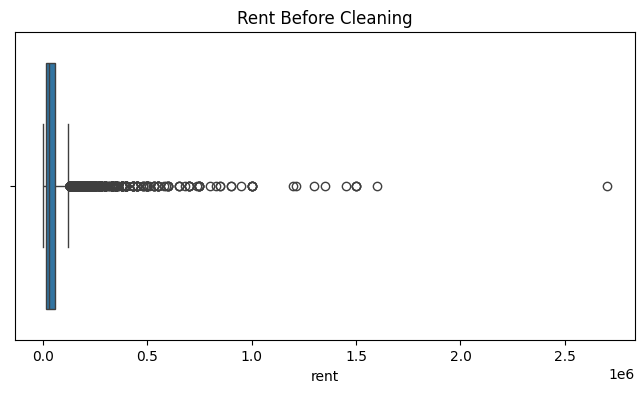

In [133]:

plt.figure(figsize=(8,4))
sns.boxplot(x=df["rent"])
plt.title("Rent Before Cleaning")
plt.show()


##  Remove Outliers using IQR Method

In [134]:

Q1 = df["rent"].quantile(0.25)
Q3 = df["rent"].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df = df[(df["rent"] >= lower) & (df["rent"] <= upper)]

df.shape


(6978, 10)

##  Check Outliers After Cleaning

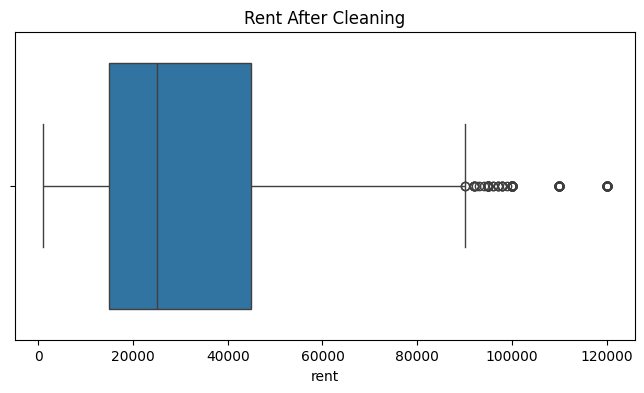

In [135]:

plt.figure(figsize=(8,4))
sns.boxplot(x=df["rent"])
plt.title("Rent After Cleaning")
plt.show()


## Encode Furnishing Column

In [136]:

furnishing_map = {
    "Unfurnished": 0,
    "Semi-Furnished": 1,
    "Furnished": 2
}

df["furnishing_score"] = df["furnishing"].map(furnishing_map)
df.drop("furnishing", axis=1, inplace=True)


##  Extract BHK from House Type

In [137]:

df["bhk"] = df["house_type"].str.extract("(\d+)").astype(int)
df.drop("house_type", axis=1, inplace=True)


##  Remove area_rate (Data Leakage)

In [138]:

df.drop("area_rate", axis=1, inplace=True)


##  Log Transformation of Rent

In [139]:

df["rent_log"] = np.log1p(df["rent"])


##  Separate Features and Target

In [140]:

X = df.drop(["rent", "rent_log",'beds'], axis=1)
y = df["rent_log"]


##  Train Test Split

In [141]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


## Column Types

In [142]:

num_cols = ["area", "bathrooms", "balconies", "bhk", "furnishing_score"]
cat_cols = ["city", "locality"]

## Preprocessing

In [143]:

preprocessor = ColumnTransformer([
    
    # Scale Numbers
    ("num", StandardScaler(), num_cols),
    
    # Encode Categories
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)

])


## Build Pipeline

In [144]:
model = Pipeline([
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])



## 16. Train Linear Regression Model

In [145]:
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##  Predict

In [ ]:

log_pred = model.predict(input_data)[0]

prediction = np.expm1(log_pred)


## 17. Evaluate Model

In [147]:

print("R2 Score :", r2_score(y_test, y_pred))
print("MAE      :", mean_absolute_error(y_test, y_pred))
print("RMSE     :", np.sqrt(mean_squared_error(y_test, y_pred)))

R2 Score : 0.6863991901757798
MAE      : 0.32540955077376144
RMSE     : 0.43225631367770506


## 18. Save Model Files

In [148]:
import joblib


# Save trained Linear Regression model
joblib.dump(model, "linear_model.pkl")

# Save OneHotEncoder for city column
joblib.dump(ohe, "city_encoder.pkl")

# Save locality mean encoder (target encoding)
joblib.dump(locality_mean, "locality_encoder.pkl")

# Save global mean (for unknown locality)
joblib.dump(global_mean, "global_mean.pkl")

# Save StandardScaler (for numerical features)
joblib.dump(scaler, "scaler.pkl")


print("All model files saved successfully!")


All model files saved successfully!


In [149]:
# import joblib

# # Load saved files
# model = joblib.load("linear_model.pkl")
# ohe = joblib.load("city_encoder.pkl")
# locality_mean = joblib.load("locality_encoder.pkl")
# global_mean = joblib.load("global_mean.pkl")
# scaler = joblib.load("scaler.pkl")

# print("All files loaded successfully!")



In [150]:
import numpy as np

print(np.log1p(25000))  # ≈ 10.12


10.12667110305036
